In [1]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
import torch
from tqdm import tqdm

In [2]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "vehicle":
        return 1

    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target
    
class RadarDataset(object):
    def __init__(self, transforms, path):
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'val' in self.path:
            label_path = os.path.join("../Ex3_final/data/"+weather+"/annotations_val/", file_label)
        elif 'test' in self.path:
            label_path = os.path.join('/home/aimotion/Desktop/Radiate/Experiment/Ex1/data/annotations_test/', file_label)
        else:
            label_path = os.path.join("../Ex3_final/data/"+weather+"/annotations_train/", file_label)

        img = Image.open(img_path)
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

def collate_fn(batch):
    return tuple(zip(*batch))

# load model
def get_model_instance_segmentation(num_classes):  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):  # outputs=preds_adj_all, targets=annot_all

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i] # predict
        # pred_boxes = output['boxes']
        # pred_scores = output['scores']
        # pred_labels = output['labels']

        true_positives = torch.zeros(output['boxes'].shape[0])   # The number of predicted objects
        annotations = targets[sample_i]  # ground-truth
        target_labels = annotations['labels'] if len(annotations) else []
        if len(annotations):    # len(annotations) = 3
            detected_boxes = []
            target_boxes = annotations['boxes']

            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])): 
                
                # If targets are found break
                if len(detected_boxes) == len(target_labels): # annotations -> target_labels
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)   # box_index : 실제 어떤 바운딩 박스랑 IoU 가 가장 높은지 index
                if iou >= iou_threshold and box_index not in detected_boxes: # iou만 맞으면 통과?
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]  # 예측된거랑 실제랑 매핑해서 하나씩 index 채움
        batch_metrics.append([true_positives, output['scores'], output['labels']])
    return batch_metrics

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)   # 2가 거의 예측안됨

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

data_transform = transforms.Compose([ 
        transforms.ToTensor() 
    ])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



class RadarDataset_fog(object):
    def __init__(self, transforms, path):
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        
        img_path = os.path.join(self.path, file_image)
        label_path = os.path.join('./test/annotations_test_fog/', file_label)

        img = Image.open(img_path)
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([ 
        transforms.ToTensor() 
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

class RadarDataset_rain(object):
    def __init__(self, transforms, path):
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        
        img_path = os.path.join(self.path, file_image)
        label_path = os.path.join('./test/annotations_test_rain/', file_label)

        img = Image.open(img_path)
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([ 
        transforms.ToTensor() 
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

class RadarDataset_sunny(object):
    def __init__(self, transforms, path):
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        
        img_path = os.path.join(self.path, file_image)
        label_path = os.path.join('./test/annotations_test_sunny/', file_label)

        img = Image.open(img_path)
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([ 
        transforms.ToTensor() 
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

In [3]:
test_dataset_fog = RadarDataset_fog(data_transform, './test/images_test_fog/')
test_data_loader_fog = torch.utils.data.DataLoader(test_dataset_fog, batch_size=1, collate_fn=collate_fn)

test_dataset_rain = RadarDataset_rain(data_transform, './test/images_test_rain/')
test_data_loader_rain = torch.utils.data.DataLoader(test_dataset_rain, batch_size=1, collate_fn=collate_fn)

test_dataset_sunny = RadarDataset_sunny(data_transform, './test/images_test_sunny/')
test_data_loader_sunny = torch.utils.data.DataLoader(test_dataset_sunny, batch_size=1, collate_fn=collate_fn)

In [4]:
number_epoch = 50

sunny_epoch_loss_list = []
rain_epoch_loss_list = []
fog_epoch_loss_list = []
sunny_val_epoch_loss_list = []
rain_val_epoch_loss_list = []
fog_val_epoch_loss_list = []
sunny_mAP_list = []
rain_mAP_list = []
fog_mAP_list = []
mAP_list = []


for i in range(number_epoch) :
    #Load sunny model
    model_sunny = get_model_instance_segmentation(2)
    model_sunny.to(device)
    model_sunny.load_state_dict(torch.load('./model/sunny_rpn_'+str(i+1)+'.pt'))
    model_sunny.eval()
    
    #Load fog model
    model = get_model_instance_segmentation(2)
    model.to(device)
    model.load_state_dict(torch.load('./model/fog_rpn_'+str(i+1)+'.pt'))
    model.eval()
    
    #Change heads of the last model (-> sunny)
    model.roi_heads.state_dict().update(model_sunny.roi_heads.state_dict())
    model.rpn.state_dict().update(model_sunny.rpn.state_dict())
    model.roi_heads.load_state_dict(model_sunny.roi_heads.state_dict())
    model.rpn.load_state_dict(model_sunny.rpn.state_dict())
    model.eval()
    
    # Training with sunny data
    num_epochs = 1
    lr=0.00001
    weather = 'sunny'
    optimizer = torch.optim.Adam(model.parameters(), lr)
    dataset = RadarDataset(data_transform, '../Ex3_final/data/'+weather+'/images_train/')
    train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=True)
    val_dataset = RadarDataset(data_transform, '../Ex3_final/data/'+weather+'/images_val')
    val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=False)



    for epoch in range(num_epochs):
        start = time.time()
        epoch_loss = 0
        val_epoch_loss = 0
        model.train()
    
        # Valdiation data
        for imgs, targets in tqdm(val_data_loader, 'Iterating validation dataset'):
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            with torch.no_grad():
                loss_dict = model(imgs, targets) 
            losses = sum(loss for loss in loss_dict.values())
            val_epoch_loss += losses.item()
        sunny_val_epoch_loss = val_epoch_loss/len(val_data_loader)

        # Train data
        for imgs, targets in tqdm(train_data_loader, 'Iterating training dataset'):
            optimizer.zero_grad()
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(imgs, targets) 
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()
            losses.backward()
            optimizer.step()
        sunny_epoch_loss = epoch_loss/len(train_data_loader)
    
        # AP Caculation
        labels = []
        preds_adj_all = []
        annot_all = []
        for imgs, targets in tqdm(val_data_loader, 'Calculating AP'):
            im = list(img.to(device) for img in imgs)
            for t in targets:
                labels += t['labels']
            with torch.no_grad():
                preds_adj = make_prediction(model, im, 0.5)
                preds_adj = [{k: v.to('cpu') for k, v in t.items()} for t in preds_adj]
                preds_adj_all.append(preds_adj)
                annot_all.append(targets)
        sample_metrics = []
        for batch_i in range(len(preds_adj_all)):
            sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 
        true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
        precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
        sunny_mAP = torch.mean(AP)
    
        sunny_epoch_loss_list.append(sunny_epoch_loss) 
        sunny_val_epoch_loss_list.append(sunny_val_epoch_loss)
        sunny_mAP_list.append(sunny_mAP)
        
        print('Train :'+weather+'_'+str(i+1))
        print(f'epoch : {i+1}, Train Loss : {sunny_epoch_loss}, Val Loss : {sunny_val_epoch_loss}, Time : {time.time() - start}, AP : {sunny_mAP}')
        torch.save(model.state_dict(), './model/sunny_rpn_'+str(i+2)+'.pt')
        
    # Load rain model
    model_rain = get_model_instance_segmentation(2)
    model_rain.to(device)
    model_rain.load_state_dict(torch.load('./model/rain_rpn_'+str(i+1)+'.pt'))
    model_rain.eval()
        
    #Change heads of the last model (-> rain)
    model.roi_heads.state_dict().update(model_rain.roi_heads.state_dict())
    model.rpn.state_dict().update(model_rain.rpn.state_dict())
    model.roi_heads.load_state_dict(model_rain.roi_heads.state_dict())
    model.rpn.load_state_dict(model_rain.rpn.state_dict())
    model.eval()
    
    # Training with rain data
    num_epochs = 1
    lr=0.00001
    weather = 'rain'
    optimizer = torch.optim.Adam(model.parameters(), lr)
    dataset = RadarDataset(data_transform, '../Ex3_final/data/'+weather+'/images_train/')
    train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=True)
    val_dataset = RadarDataset(data_transform, '../Ex3_final/data/'+weather+'/images_val')
    val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=False)

    

    for epoch in range(num_epochs):
        start = time.time()
        epoch_loss = 0
        val_epoch_loss = 0
        model.train()
    
        # Valdiation data
        for imgs, targets in tqdm(val_data_loader, 'Iterating validation dataset'):
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            with torch.no_grad():
                loss_dict = model(imgs, targets) 
            losses = sum(loss for loss in loss_dict.values())
            val_epoch_loss += losses.item()
        rain_val_epoch_loss = val_epoch_loss/len(val_data_loader)

        # Train data
        for imgs, targets in tqdm(train_data_loader, 'Iterating training dataset'):
            optimizer.zero_grad()
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(imgs, targets) 
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()
            losses.backward()
            optimizer.step()
        rain_epoch_loss = epoch_loss/len(train_data_loader)
    
        # AP Caculation
        labels = []
        preds_adj_all = []
        annot_all = []
        for imgs, targets in tqdm(val_data_loader, 'Calculating AP'):
            im = list(img.to(device) for img in imgs)
            for t in targets:
                labels += t['labels']
            with torch.no_grad():
                preds_adj = make_prediction(model, im, 0.5)
                preds_adj = [{k: v.to('cpu') for k, v in t.items()} for t in preds_adj]
                preds_adj_all.append(preds_adj)
                annot_all.append(targets)
        sample_metrics = []
        for batch_i in range(len(preds_adj_all)):
            sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 
        true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
        precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
        rain_mAP = torch.mean(AP)
    
        rain_epoch_loss_list.append(rain_epoch_loss) 
        rain_val_epoch_loss_list.append(rain_val_epoch_loss)
        rain_mAP_list.append(rain_mAP)
    
        print('Train :'+weather+'_'+str(i+1))
        print(f'epoch : {i+1}, Train Loss : {rain_epoch_loss}, Val Loss : {rain_val_epoch_loss}, Time : {time.time() - start}, AP : {rain_mAP}')
        torch.save(model.state_dict(), './model/rain_rpn_'+str(i+2)+'.pt')
        
    # Load fog model
    model_fog = get_model_instance_segmentation(2)
    model_fog.to(device)
    model_fog.load_state_dict(torch.load('./model/fog_rpn_'+str(i+1)+'.pt'))
    model_fog.eval()
        
    #Change heads of the last model (-> fog)
    model.roi_heads.state_dict().update(model_fog.roi_heads.state_dict())
    model.rpn.state_dict().update(model_fog.rpn.state_dict())
    model.roi_heads.load_state_dict(model_fog.roi_heads.state_dict())
    model.rpn.load_state_dict(model_fog.rpn.state_dict())
    model.eval()
    
    # Training with fog data
    num_epochs = 1
    lr=0.00001
    weather = 'fog'
    optimizer = torch.optim.Adam(model.parameters(), lr)
    dataset = RadarDataset(data_transform, '../Ex3_final/data/'+weather+'/images_train/')
    train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=True)
    val_dataset = RadarDataset(data_transform, '../Ex3_final/data/'+weather+'/images_val')
    val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn, num_workers=1, shuffle=False)


    for epoch in range(num_epochs):
        start = time.time()
        epoch_loss = 0
        val_epoch_loss = 0
        model.train()
    
        # Valdiation data
        for imgs, targets in tqdm(val_data_loader, 'Iterating validation dataset'):
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            with torch.no_grad():
                loss_dict = model(imgs, targets) 
            losses = sum(loss for loss in loss_dict.values())
            val_epoch_loss += losses.item()
        fog_val_epoch_loss = val_epoch_loss/len(val_data_loader)

        # Train data
        for imgs, targets in tqdm(train_data_loader, 'Iterating training dataset'):
            optimizer.zero_grad()
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(imgs, targets) 
            losses = sum(loss for loss in loss_dict.values())
            epoch_loss += losses.item()
            losses.backward()
            optimizer.step()
        fog_epoch_loss = epoch_loss/len(train_data_loader)
    
        # AP Caculation
        labels = []
        preds_adj_all = []
        annot_all = []
        for imgs, targets in tqdm(val_data_loader, 'Calculating AP'):
            im = list(img.to(device) for img in imgs)
            for t in targets:
                labels += t['labels']
            with torch.no_grad():
                preds_adj = make_prediction(model, im, 0.5)
                preds_adj = [{k: v.to('cpu') for k, v in t.items()} for t in preds_adj]
                preds_adj_all.append(preds_adj)
                annot_all.append(targets)
        sample_metrics = []
        for batch_i in range(len(preds_adj_all)):
            sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 
        true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
        precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
        fog_mAP = torch.mean(AP)
    
        fog_epoch_loss_list.append(fog_epoch_loss) 
        fog_val_epoch_loss_list.append(fog_val_epoch_loss)
        fog_mAP_list.append(fog_mAP)
        
        print('Train :'+weather+'_'+str(i+1))
        print(f'epoch : {i+1}, Train Loss : {fog_epoch_loss}, Val Loss : {fog_val_epoch_loss}, Time : {time.time() - start}, AP : {fog_mAP}')
        torch.save(model.state_dict(), './model/fog_rpn_'+str(i+2)+'.pt')
        

    #### Evaluation ####
    # Load models
    model_sunny = get_model_instance_segmentation(2)
    model_sunny.to(device)
    model_sunny.load_state_dict(torch.load('./model/sunny_rpn_'+str(i+2)+'.pt'))
    model_sunny.eval()

    model_rain = get_model_instance_segmentation(2)
    model_rain.to(device)
    model_rain.load_state_dict(torch.load('./model/rain_rpn_'+str(i+2)+'.pt'))
    model_rain.eval()

    model_last = get_model_instance_segmentation(2)
    model_last.to(device)
    model_last.load_state_dict(torch.load('./model/fog_rpn_'+str(i+2)+'.pt'))
    model_last.eval()
    
    # sunny model
    model_last.roi_heads.state_dict().update(model_sunny.roi_heads.state_dict())
    model_last.rpn.state_dict().update(model_sunny.rpn.state_dict())
    model_last.rpn.load_state_dict(model_sunny.rpn.state_dict())
    model_last.roi_heads.load_state_dict(model_sunny.roi_heads.state_dict())
    model_last.eval()
    model_sunny = model_last

    # rain model
    model_s = get_model_instance_segmentation(2)
    model_s.to(device)
    model_s.load_state_dict(torch.load('./model/fog_rpn_'+str(i+2)+'.pt'))
    model_s.eval()

    model_s.roi_heads.state_dict().update(model_rain.roi_heads.state_dict())
    model_s.rpn.state_dict().update(model_rain.rpn.state_dict())
    model_s.roi_heads.load_state_dict(model_rain.roi_heads.state_dict())
    model_s.rpn.load_state_dict(model_rain.rpn.state_dict())
    model_s.eval()
    model_rain = model_s

    # fog model
    model_fog = get_model_instance_segmentation(2)
    model_fog.to(device)
    model_fog.load_state_dict(torch.load('./model/fog_rpn_'+str(i+2)+'.pt'))
    model_fog.eval()
    
    
    # fog 
    model = model_fog

    labels_fog = []
    preds_adj_all_fog = []
    annot_all_fog = []

    for im, annot in tqdm(test_data_loader_fog, position = 0, leave = True):
        im = list(img.to(device) for img in im)
  
        for t in annot:
            labels_fog += t['labels']

        with torch.no_grad():
            preds_adj_fog = make_prediction(model, im, 0.5)
            preds_adj_fog = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj_fog]
            preds_adj_all_fog.append(preds_adj_fog)
            annot_all_fog.append(annot)
            
    #rain
    model = model_rain

    labels_rain = []
    preds_adj_all_rain = []
    annot_all_rain = []

    for im, annot in tqdm(test_data_loader_rain, position = 0, leave = True):
        im = list(img.to(device) for img in im)
        #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

        for t in annot:
            labels_rain += t['labels']

        with torch.no_grad():
            preds_adj_rain = make_prediction(model, im, 0.5)
            preds_adj_rain = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj_rain]
            preds_adj_all_rain.append(preds_adj_rain)
            annot_all_rain.append(annot)
            
    #sunny

    model = model_sunny

    labels_sunny = []
    preds_adj_all_sunny = []
    annot_all_sunny = []
    
    for im, annot in tqdm(test_data_loader_sunny, position = 0, leave = True):
        im = list(img.to(device) for img in im)
        #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

        for t in annot:
            labels_sunny += t['labels']

        with torch.no_grad():
            preds_adj_sunny = make_prediction(model, im, 0.5)
            preds_adj_sunny = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj_sunny]
            preds_adj_all_sunny.append(preds_adj_sunny)
            annot_all_sunny.append(annot)
    
    # Sum up all data from different networks
    preds_adj_all = preds_adj_all_fog + preds_adj_all_rain + preds_adj_all_sunny
    annot_all = annot_all_fog + annot_all_rain + annot_all_sunny
    labels = labels_fog + labels_rain + labels_sunny
    
    #AP
    sample_metrics = []

    for batch_i in range(len(preds_adj_all)): # len(preds_adj_all) : The number of batches
        sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

    true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
    mAP = torch.mean(AP)
    mAP_list.append(mAP)
    
    print(f'epoch{i+1}_AP:{mAP}')

Calculating AP: 100%|█████████████████████████| 149/149 [00:18<00:00,  8.23it/s]


Train :sunny_1
epoch : 1, Train Loss : 0.10454947698137519, Val Loss : 0.2209819981315792, Time : 361.0790240764618, AP : 0.9536222534005638


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.20it/s]


Train :rain_1
epoch : 1, Train Loss : 0.3545984272887984, Val Loss : 0.8159632841125131, Time : 387.6439392566681, AP : 0.8142745790518031


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.16it/s]


Train :fog_1
epoch : 1, Train Loss : 0.09223917377823719, Val Loss : 0.1393173490292751, Time : 126.47357535362244, AP : 0.9479756599167715


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.25it/s]


epoch1_AP:0.790797256972789


Calculating AP: 100%|█████████████████████████| 149/149 [00:18<00:00,  8.27it/s]


Train :sunny_2
epoch : 2, Train Loss : 0.0875316814892306, Val Loss : 0.11280932622467911, Time : 361.6549232006073, AP : 0.9525412980876524


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.22it/s]


Train :rain_2
epoch : 2, Train Loss : 0.3191655637066779, Val Loss : 0.6798160278238357, Time : 387.98637318611145, AP : 0.8293679732867849


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  7.98it/s]


Train :fog_2
epoch : 2, Train Loss : 0.08504497162055287, Val Loss : 0.11532275640190794, Time : 126.83117079734802, AP : 0.9451968415836767


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.32it/s]


epoch2_AP:0.7896103019517042


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_3
epoch : 3, Train Loss : 0.08059654075658601, Val Loss : 0.11739600557308869, Time : 360.01803970336914, AP : 0.9673178491429972


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.29it/s]


Train :rain_3
epoch : 3, Train Loss : 0.2985404694974888, Val Loss : 0.6324372645933181, Time : 386.3660559654236, AP : 0.8446024184491581


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.20it/s]


Train :fog_3
epoch : 3, Train Loss : 0.07982100555250923, Val Loss : 0.12420535796823409, Time : 126.22203588485718, AP : 0.9456068582451671


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.34it/s]


epoch3_AP:0.8364209203929969


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_4
epoch : 4, Train Loss : 0.074434493886778, Val Loss : 0.10427613221358933, Time : 360.4005391597748, AP : 0.9626771512748995


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.27it/s]


Train :rain_4
epoch : 4, Train Loss : 0.2822211536053193, Val Loss : 0.5568875560536981, Time : 386.5865230560303, AP : 0.855072028855866


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.20it/s]


Train :fog_4
epoch : 4, Train Loss : 0.07347298771818668, Val Loss : 0.11293045617640018, Time : 126.40321159362793, AP : 0.9568429140526611


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.35it/s]


epoch4_AP:0.8617044351380514


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_5
epoch : 5, Train Loss : 0.0689035800521198, Val Loss : 0.10406226734787026, Time : 360.21731090545654, AP : 0.9627107247111368


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.28it/s]


Train :rain_5
epoch : 5, Train Loss : 0.2672196112887223, Val Loss : 0.5523613131139428, Time : 386.7988135814667, AP : 0.8595904959295932


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_5
epoch : 5, Train Loss : 0.0703070016804558, Val Loss : 0.11504057239597806, Time : 126.48886489868164, AP : 0.9515405605934504


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.24it/s]


epoch5_AP:0.8726575948044513


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.35it/s]


Train :sunny_6
epoch : 6, Train Loss : 0.06463176891257615, Val Loss : 0.10168575102950903, Time : 360.0322380065918, AP : 0.9676551293637274


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.31it/s]


Train :rain_6
epoch : 6, Train Loss : 0.25468362833807284, Val Loss : 0.5326692994683981, Time : 387.02712965011597, AP : 0.8522510727573405


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.24it/s]


Train :fog_6
epoch : 6, Train Loss : 0.06659796800873373, Val Loss : 0.11454156633967963, Time : 126.5864372253418, AP : 0.9413035690503051


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.34it/s]


epoch6_AP:0.8709059149889047


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.35it/s]


Train :sunny_7
epoch : 7, Train Loss : 0.06140267075596368, Val Loss : 0.10044483957349654, Time : 360.31936502456665, AP : 0.9612250258478454


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.29it/s]


Train :rain_7
epoch : 7, Train Loss : 0.2393822157021196, Val Loss : 0.5406492742244154, Time : 387.0190510749817, AP : 0.8734224499889827


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_7
epoch : 7, Train Loss : 0.06347973895457024, Val Loss : 0.11041712449290432, Time : 126.7084367275238, AP : 0.9406733522253532


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.37it/s]


epoch7_AP:0.8722020773588142


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_8
epoch : 8, Train Loss : 0.05820253578059912, Val Loss : 0.11524772684046086, Time : 360.76328778266907, AP : 0.9639342235977644


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.32it/s]


Train :rain_8
epoch : 8, Train Loss : 0.22783048480027918, Val Loss : 0.4794866227544844, Time : 387.0088486671448, AP : 0.8717345935280827


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_8
epoch : 8, Train Loss : 0.05906166505904286, Val Loss : 0.11647846900786345, Time : 126.83370327949524, AP : 0.9374873682995073


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.38it/s]


epoch8_AP:0.8951234634664127


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.31it/s]


Train :sunny_9
epoch : 9, Train Loss : 0.05473900146445437, Val Loss : 0.09973866403127876, Time : 360.84273171424866, AP : 0.9655176092914992


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.28it/s]


Train :rain_9
epoch : 9, Train Loss : 0.2154215078576992, Val Loss : 0.45993330907076596, Time : 387.31983947753906, AP : 0.8828516851083572


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_9
epoch : 9, Train Loss : 0.05572534192949178, Val Loss : 0.10928438234931001, Time : 126.92255663871765, AP : 0.9317318786022355


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.36it/s]


epoch9_AP:0.8697744870795772


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_10
epoch : 10, Train Loss : 0.05206925169778504, Val Loss : 0.11737423141380685, Time : 360.50765895843506, AP : 0.9626947781189976


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_10
epoch : 10, Train Loss : 0.20381493232475417, Val Loss : 0.4600280693266541, Time : 387.3865442276001, AP : 0.872598114241014


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_10
epoch : 10, Train Loss : 0.05331505718363142, Val Loss : 0.1178686939036617, Time : 126.82232141494751, AP : 0.941134628772371


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.36it/s]


epoch10_AP:0.8744543353836374


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.35it/s]


Train :sunny_11
epoch : 11, Train Loss : 0.04926223996004879, Val Loss : 0.10400455813204883, Time : 360.4569773674011, AP : 0.9522543622577011


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.29it/s]


Train :rain_11
epoch : 11, Train Loss : 0.19391035794729045, Val Loss : 0.4789711714256555, Time : 387.35458612442017, AP : 0.8824365103041067


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.22it/s]


Train :fog_11
epoch : 11, Train Loss : 0.04959567302397868, Val Loss : 0.11041242252283084, Time : 126.91674470901489, AP : 0.9348582896967059


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.42it/s]


epoch11_AP:0.8765294906064369


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.30it/s]


Train :sunny_12
epoch : 12, Train Loss : 0.04634177335264969, Val Loss : 0.11170552247172634, Time : 360.6479022502899, AP : 0.9529063501084316


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.32it/s]


Train :rain_12
epoch : 12, Train Loss : 0.18373538998074126, Val Loss : 0.4762931443285197, Time : 387.14696741104126, AP : 0.879148685206963


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_12
epoch : 12, Train Loss : 0.04686730089964154, Val Loss : 0.1221045556728943, Time : 127.02646040916443, AP : 0.939933000432152


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.17it/s]


epoch12_AP:0.8814248295854874


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_13
epoch : 13, Train Loss : 0.044129359452412704, Val Loss : 0.10846243831860339, Time : 360.46762919425964, AP : 0.9503576322131941


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.31it/s]


Train :rain_13
epoch : 13, Train Loss : 0.17497595919297598, Val Loss : 0.46511981217190623, Time : 387.8918504714966, AP : 0.8799959851713677


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_13
epoch : 13, Train Loss : 0.04310779736726267, Val Loss : 0.12039280847574656, Time : 126.92611575126648, AP : 0.9340080907906874


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.24it/s]


epoch13_AP:0.8978357882035448


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_14
epoch : 14, Train Loss : 0.04167344289405936, Val Loss : 0.11515823333530419, Time : 360.8653244972229, AP : 0.9548406667687317


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_14
epoch : 14, Train Loss : 0.16585888056365147, Val Loss : 0.43711981517262755, Time : 387.62228202819824, AP : 0.8829959540149028


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_14
epoch : 14, Train Loss : 0.041437101321459384, Val Loss : 0.12251405503887397, Time : 126.87249207496643, AP : 0.9417890619686773


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.36it/s]


epoch14_AP:0.8908654392922202


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_15
epoch : 15, Train Loss : 0.03960123059996583, Val Loss : 0.1093193439566749, Time : 360.42150688171387, AP : 0.9485250296786312


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_15
epoch : 15, Train Loss : 0.15869937501818662, Val Loss : 0.489825376868248, Time : 387.60723066329956, AP : 0.8872535335337242


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.22it/s]


Train :fog_15
epoch : 15, Train Loss : 0.0390397216502337, Val Loss : 0.11931101888274917, Time : 127.07234263420105, AP : 0.9460309721487157


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.34it/s]


epoch15_AP:0.8951692211267286


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.32it/s]


Train :sunny_16
epoch : 16, Train Loss : 0.03728382385427903, Val Loss : 0.1112501061077686, Time : 360.7359251976013, AP : 0.9523007449249228


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_16
epoch : 16, Train Loss : 0.15049278168160407, Val Loss : 0.47785162734799086, Time : 387.79496455192566, AP : 0.8903379501270896


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_16
epoch : 16, Train Loss : 0.03599728465186952, Val Loss : 0.12143370793917431, Time : 127.14153289794922, AP : 0.9438552645319049


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.31it/s]


epoch16_AP:0.8988902644837475


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_17
epoch : 17, Train Loss : 0.035379810566066996, Val Loss : 0.11344619697872424, Time : 360.54520773887634, AP : 0.9483096678817233


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.26it/s]


Train :rain_17
epoch : 17, Train Loss : 0.14257652651821026, Val Loss : 0.5169631108641625, Time : 388.1350977420807, AP : 0.882211764616061


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_17
epoch : 17, Train Loss : 0.0338207933604984, Val Loss : 0.11871424986300273, Time : 127.10493516921997, AP : 0.9463425173585986


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.27it/s]


epoch17_AP:0.8933229987090732


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.32it/s]


Train :sunny_18
epoch : 18, Train Loss : 0.032723154196393996, Val Loss : 0.11849523569463484, Time : 360.71673822402954, AP : 0.9454434778118745


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.28it/s]


Train :rain_18
epoch : 18, Train Loss : 0.13596752330596842, Val Loss : 0.4721094922628254, Time : 387.96537828445435, AP : 0.8800331640850354


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_18
epoch : 18, Train Loss : 0.0315368978966801, Val Loss : 0.13865870935842395, Time : 127.09337854385376, AP : 0.938883787471056


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.34it/s]


epoch18_AP:0.8901742296025628


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_19
epoch : 19, Train Loss : 0.03182735366955824, Val Loss : 0.12302509083993883, Time : 360.55534839630127, AP : 0.9485612716616281


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.31it/s]


Train :rain_19
epoch : 19, Train Loss : 0.12981767455373283, Val Loss : 0.5209217741154134, Time : 387.5993323326111, AP : 0.874624508909617


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_19
epoch : 19, Train Loss : 0.03020954949932444, Val Loss : 0.12931925427311888, Time : 127.03837490081787, AP : 0.9449457340804293


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.23it/s]


epoch19_AP:0.8899579826866315


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_20
epoch : 20, Train Loss : 0.03059163450737682, Val Loss : 0.11806423512081173, Time : 360.3031952381134, AP : 0.9491104628798297


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_20
epoch : 20, Train Loss : 0.1242126888951038, Val Loss : 0.5020250568166376, Time : 387.64313197135925, AP : 0.8800835317889293


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_20
epoch : 20, Train Loss : 0.02848585572444916, Val Loss : 0.13165085014099112, Time : 126.99035859107971, AP : 0.9470857792308474


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.37it/s]


epoch20_AP:0.8978919044613667


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_21
epoch : 21, Train Loss : 0.029295683512776168, Val Loss : 0.11848826420762194, Time : 360.6605715751648, AP : 0.945451362123908


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.28it/s]


Train :rain_21
epoch : 21, Train Loss : 0.11833735689983226, Val Loss : 0.4880542112980038, Time : 387.81727862358093, AP : 0.8895371553344997


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.20it/s]


Train :fog_21
epoch : 21, Train Loss : 0.02656656439996242, Val Loss : 0.12389699065198119, Time : 127.1322808265686, AP : 0.9484665203521558


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.35it/s]


epoch21_AP:0.9003502191431227


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_22
epoch : 22, Train Loss : 0.027385867183241788, Val Loss : 0.1198727338193547, Time : 360.4865083694458, AP : 0.9485878104092791


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.31it/s]


Train :rain_22
epoch : 22, Train Loss : 0.11394161841076719, Val Loss : 0.5218695880612358, Time : 388.0343265533447, AP : 0.8877122721580264


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.24it/s]


Train :fog_22
epoch : 22, Train Loss : 0.02567186703914354, Val Loss : 0.12901810694557542, Time : 127.13182497024536, AP : 0.9462776738150609


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.27it/s]


epoch22_AP:0.8966486886956275


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_23
epoch : 23, Train Loss : 0.026265759153644146, Val Loss : 0.11953264016708072, Time : 360.60708022117615, AP : 0.9443336095639836


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.31it/s]


Train :rain_23
epoch : 23, Train Loss : 0.10942054153503639, Val Loss : 0.4861036868300289, Time : 388.2148628234863, AP : 0.8820028616671909


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.20it/s]


Train :fog_23
epoch : 23, Train Loss : 0.024149427240434368, Val Loss : 0.13783357182266906, Time : 127.26827907562256, AP : 0.9486956542307787


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.36it/s]


epoch23_AP:0.9020100905624799


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.31it/s]


Train :sunny_24
epoch : 24, Train Loss : 0.024897209046505255, Val Loss : 0.12022804710138964, Time : 360.73882246017456, AP : 0.9492591473548373


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.31it/s]


Train :rain_24
epoch : 24, Train Loss : 0.10462672355062068, Val Loss : 0.45107639257330445, Time : 388.1763641834259, AP : 0.8785777787856972


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.22it/s]


Train :fog_24
epoch : 24, Train Loss : 0.022559021668495313, Val Loss : 0.1339412883300191, Time : 127.20465970039368, AP : 0.949157787129467


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.27it/s]


epoch24_AP:0.8989892476570267


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.28it/s]


Train :sunny_25
epoch : 25, Train Loss : 0.023772271968957842, Val Loss : 0.12328137674887708, Time : 360.7918848991394, AP : 0.9516194598426857


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.29it/s]


Train :rain_25
epoch : 25, Train Loss : 0.09904391316596671, Val Loss : 0.49074585079215466, Time : 387.9506902694702, AP : 0.8875979445851421


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.16it/s]


Train :fog_25
epoch : 25, Train Loss : 0.02187651593509288, Val Loss : 0.12663177576345894, Time : 127.24129915237427, AP : 0.946685260616789


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.41it/s]


epoch25_AP:0.894638243791162


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_26
epoch : 26, Train Loss : 0.022825715903284798, Val Loss : 0.12734110607146817, Time : 360.5180184841156, AP : 0.9402094819653852


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_26
epoch : 26, Train Loss : 0.09678272223339986, Val Loss : 0.4874681546818465, Time : 387.9286243915558, AP : 0.8720733589708924


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_26
epoch : 26, Train Loss : 0.02113496004948326, Val Loss : 0.1317182767760152, Time : 127.13718056678772, AP : 0.9449125718224085


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.35it/s]


epoch26_AP:0.8981576982345869


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.30it/s]


Train :sunny_27
epoch : 27, Train Loss : 0.022023550696496287, Val Loss : 0.12450709017056147, Time : 360.60601592063904, AP : 0.9414622505850652


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.28it/s]


Train :rain_27
epoch : 27, Train Loss : 0.09212293685831938, Val Loss : 0.4929701612796634, Time : 388.05647468566895, AP : 0.8756725366734255


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_27
epoch : 27, Train Loss : 0.020939110129235893, Val Loss : 0.1414349682879849, Time : 127.17498660087585, AP : 0.9485494471641998


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.31it/s]


epoch27_AP:0.8962316063500722


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_28
epoch : 28, Train Loss : 0.021186897941432907, Val Loss : 0.1298801888205461, Time : 360.6257236003876, AP : 0.9414496372329024


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.31it/s]


Train :rain_28
epoch : 28, Train Loss : 0.08904630298072663, Val Loss : 0.48122540866024793, Time : 387.92650270462036, AP : 0.8775568852910816


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.22it/s]


Train :fog_28
epoch : 28, Train Loss : 0.02111010421523135, Val Loss : 0.1394326503102023, Time : 127.13106775283813, AP : 0.93320701973028


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.27it/s]


epoch28_AP:0.8921363133181908


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_29
epoch : 29, Train Loss : 0.020691494804914647, Val Loss : 0.13595650657611405, Time : 360.27065348625183, AP : 0.9427287305569241


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_29
epoch : 29, Train Loss : 0.08632823083096072, Val Loss : 0.5047050603898242, Time : 388.1785056591034, AP : 0.8864247227547422


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_29
epoch : 29, Train Loss : 0.019578710641280743, Val Loss : 0.13599929805451, Time : 127.21740102767944, AP : 0.9493786416501564


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.22it/s]


epoch29_AP:0.893735568257227


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_30
epoch : 30, Train Loss : 0.019581075875522255, Val Loss : 0.1381531809425394, Time : 360.5238199234009, AP : 0.947344625025563


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_30
epoch : 30, Train Loss : 0.08213199407609643, Val Loss : 0.5035438851453364, Time : 388.0277683734894, AP : 0.883835685122647


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_30
epoch : 30, Train Loss : 0.019286159744935204, Val Loss : 0.13439775122186312, Time : 127.21430659294128, AP : 0.9461200847704987


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.30it/s]


epoch30_AP:0.8910612329224445


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_31
epoch : 31, Train Loss : 0.019112047877192336, Val Loss : 0.1307331967048797, Time : 360.35882234573364, AP : 0.951537048588392


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_31
epoch : 31, Train Loss : 0.08085286987699702, Val Loss : 0.48456941861659286, Time : 388.204124212265, AP : 0.8825717698741506


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.19it/s]


Train :fog_31
epoch : 31, Train Loss : 0.017858165921421105, Val Loss : 0.1363614987170037, Time : 127.28274130821228, AP : 0.9508271152581234


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.18it/s]


epoch31_AP:0.8947316395856579


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.31it/s]


Train :sunny_32
epoch : 32, Train Loss : 0.018463072993549233, Val Loss : 0.1290704803791322, Time : 360.2743670940399, AP : 0.9479575024530114


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.31it/s]


Train :rain_32
epoch : 32, Train Loss : 0.07747413107440469, Val Loss : 0.524399462994188, Time : 388.21441531181335, AP : 0.8834726623724283


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_32
epoch : 32, Train Loss : 0.017671421756478903, Val Loss : 0.13825458526396409, Time : 127.13688445091248, AP : 0.9412160392950248


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.33it/s]


epoch32_AP:0.8917968032497514


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_33
epoch : 33, Train Loss : 0.01763283195761087, Val Loss : 0.13273433852165736, Time : 360.4147479534149, AP : 0.9470873604549723


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.31it/s]


Train :rain_33
epoch : 33, Train Loss : 0.07513645120767715, Val Loss : 0.5197559650987387, Time : 388.22775650024414, AP : 0.8844080990372252


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.20it/s]


Train :fog_33
epoch : 33, Train Loss : 0.0163697324029719, Val Loss : 0.13344835670879826, Time : 127.23239159584045, AP : 0.9529282411133924


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.35it/s]


epoch33_AP:0.8923099181393503


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_34
epoch : 34, Train Loss : 0.017491638235524732, Val Loss : 0.13317934493378006, Time : 360.4259412288666, AP : 0.9428087720764111


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_34
epoch : 34, Train Loss : 0.07288873263189073, Val Loss : 0.5503717916551978, Time : 388.149037361145, AP : 0.8806948584983081


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_34
epoch : 34, Train Loss : 0.016835174584418963, Val Loss : 0.14705636963928834, Time : 127.12495636940002, AP : 0.9309323776061227


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.32it/s]


epoch34_AP:0.8904346797520044


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_35
epoch : 35, Train Loss : 0.016753352660384697, Val Loss : 0.14522769655907314, Time : 360.21659302711487, AP : 0.9403807084439606


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.31it/s]


Train :rain_35
epoch : 35, Train Loss : 0.07195260435936043, Val Loss : 0.5655800357926637, Time : 388.10491275787354, AP : 0.8878499189356885


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_35
epoch : 35, Train Loss : 0.015945148237520797, Val Loss : 0.13424993934145626, Time : 127.167067527771, AP : 0.947002541056559


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.24it/s]


epoch35_AP:0.8950570181027264


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_36
epoch : 36, Train Loss : 0.01619519813530696, Val Loss : 0.13327966487947726, Time : 360.33018922805786, AP : 0.9494033423666188


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.28it/s]


Train :rain_36
epoch : 36, Train Loss : 0.06908931033133263, Val Loss : 0.490273271035403, Time : 388.2858419418335, AP : 0.8758103465837648


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.22it/s]


Train :fog_36
epoch : 36, Train Loss : 0.015756975133683276, Val Loss : 0.13656999310478568, Time : 126.99449586868286, AP : 0.956546145783296


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.40it/s]


epoch36_AP:0.9017154643413767


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.31it/s]


Train :sunny_37
epoch : 37, Train Loss : 0.015866016335917988, Val Loss : 0.13090385202843471, Time : 360.3372941017151, AP : 0.9524030270183488


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.29it/s]


Train :rain_37
epoch : 37, Train Loss : 0.06691752636229371, Val Loss : 0.49908251108136026, Time : 388.36184096336365, AP : 0.8824794676299375


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_37
epoch : 37, Train Loss : 0.015509145105422112, Val Loss : 0.13692534670162088, Time : 127.05362367630005, AP : 0.9545190303868409


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.40it/s]


epoch37_AP:0.895253122241848


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_38
epoch : 38, Train Loss : 0.01556292189974681, Val Loss : 0.13087262124473217, Time : 360.069922208786, AP : 0.9462202573883687


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.29it/s]


Train :rain_38
epoch : 38, Train Loss : 0.06565430536095539, Val Loss : 0.4958638397976756, Time : 388.13323760032654, AP : 0.8871706437484814


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_38
epoch : 38, Train Loss : 0.015020364567055088, Val Loss : 0.13838846180946207, Time : 127.17542099952698, AP : 0.9600794119255518


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.33it/s]


epoch38_AP:0.9045083076089275


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.32it/s]


Train :sunny_39
epoch : 39, Train Loss : 0.015352411397851354, Val Loss : 0.13058154433090616, Time : 360.08023381233215, AP : 0.9561743622880687


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_39
epoch : 39, Train Loss : 0.06338032363833253, Val Loss : 0.5124447919428349, Time : 388.04331254959106, AP : 0.8813118719658029


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.22it/s]


Train :fog_39
epoch : 39, Train Loss : 0.01483342023999797, Val Loss : 0.14682761672884226, Time : 127.0476176738739, AP : 0.9387528827520661


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.36it/s]


epoch39_AP:0.8943048287749384


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.31it/s]


Train :sunny_40
epoch : 40, Train Loss : 0.014793832914009097, Val Loss : 0.13335697316633374, Time : 360.0927731990814, AP : 0.9502863408790212


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_40
epoch : 40, Train Loss : 0.061594065025035845, Val Loss : 0.48828291532117873, Time : 387.9237780570984, AP : 0.8839193794761924


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.19it/s]


Train :fog_40
epoch : 40, Train Loss : 0.014315458039057425, Val Loss : 0.13828199261871094, Time : 127.07989430427551, AP : 0.9497013608314688


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.27it/s]


epoch40_AP:0.896542493955109


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.32it/s]


Train :sunny_41
epoch : 41, Train Loss : 0.014596719469506936, Val Loss : 0.13431590898024956, Time : 359.8011646270752, AP : 0.9501758086500853


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.28it/s]


Train :rain_41
epoch : 41, Train Loss : 0.06019026216135522, Val Loss : 0.4856166500132531, Time : 388.0995020866394, AP : 0.8950883809107228


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.21it/s]


Train :fog_41
epoch : 41, Train Loss : 0.01391496789099333, Val Loss : 0.13311071634794083, Time : 127.13661599159241, AP : 0.9473165163743431


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.26it/s]


epoch41_AP:0.8956684263064774


Calculating AP: 100%|█████████████████████████| 149/149 [00:18<00:00,  8.13it/s]


Train :sunny_42
epoch : 42, Train Loss : 0.013935632818363687, Val Loss : 0.13575658350932918, Time : 360.9060399532318, AP : 0.9444431428389937


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.20it/s]


Train :rain_42
epoch : 42, Train Loss : 0.05975213152000929, Val Loss : 0.5485108755994588, Time : 390.34608149528503, AP : 0.8793705127583742


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.15it/s]


Train :fog_42
epoch : 42, Train Loss : 0.013172214804106084, Val Loss : 0.14581932331202552, Time : 127.54375720024109, AP : 0.9343244006401186


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.32it/s]


epoch42_AP:0.8916951303859944


Calculating AP: 100%|█████████████████████████| 149/149 [00:18<00:00,  8.25it/s]


Train :sunny_43
epoch : 43, Train Loss : 0.013825966249425994, Val Loss : 0.1391108770160967, Time : 361.4048981666565, AP : 0.9449813782653091


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.27it/s]


Train :rain_43
epoch : 43, Train Loss : 0.05857404490502422, Val Loss : 0.5226232461165636, Time : 387.62443137168884, AP : 0.8859043696750195


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.07it/s]


Train :fog_43
epoch : 43, Train Loss : 0.013434412181244047, Val Loss : 0.13769046113324854, Time : 127.88313221931458, AP : 0.9565858277863981


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.19it/s]


epoch43_AP:0.9019929952989019


Calculating AP: 100%|█████████████████████████| 149/149 [00:18<00:00,  8.27it/s]


Train :sunny_44
epoch : 44, Train Loss : 0.013688511447396, Val Loss : 0.13024120602831746, Time : 361.3103573322296, AP : 0.9471234437653173


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.24it/s]


Train :rain_44
epoch : 44, Train Loss : 0.05723682148920068, Val Loss : 0.5409548301715403, Time : 389.1971092224121, AP : 0.8820949670945755


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.16it/s]


Train :fog_44
epoch : 44, Train Loss : 0.01353984614967553, Val Loss : 0.14308699822196594, Time : 127.36771774291992, AP : 0.9421864485313982


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.21it/s]


epoch44_AP:0.8899328892293816


Calculating AP: 100%|█████████████████████████| 149/149 [00:18<00:00,  8.26it/s]


Train :sunny_45
epoch : 45, Train Loss : 0.013723714351638452, Val Loss : 0.14520719762416495, Time : 360.8793168067932, AP : 0.9463920332933462


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.23it/s]


Train :rain_45
epoch : 45, Train Loss : 0.05584495728086625, Val Loss : 0.5326201378833503, Time : 389.2181854248047, AP : 0.8829616921544234


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.15it/s]


Train :fog_45
epoch : 45, Train Loss : 0.013115240971675601, Val Loss : 0.1410247454813753, Time : 127.37760066986084, AP : 0.9489917161325785


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.28it/s]


epoch45_AP:0.8962253401003588


Calculating AP: 100%|█████████████████████████| 149/149 [00:18<00:00,  8.27it/s]


Train :sunny_46
epoch : 46, Train Loss : 0.012959163427123584, Val Loss : 0.13824127530741612, Time : 361.17723202705383, AP : 0.9446681800483905


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.25it/s]


Train :rain_46
epoch : 46, Train Loss : 0.055371912438742336, Val Loss : 0.5254214290063828, Time : 388.9251501560211, AP : 0.8810755996070956


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.13it/s]


Train :fog_46
epoch : 46, Train Loss : 0.012777073652236801, Val Loss : 0.1421516056602391, Time : 127.43098902702332, AP : 0.9460532258323511


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.29it/s]


epoch46_AP:0.8941420304732306


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.33it/s]


Train :sunny_47
epoch : 47, Train Loss : 0.012965047533875035, Val Loss : 0.13406595000184623, Time : 359.4842028617859, AP : 0.9493587129624874


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.34it/s]


Train :rain_47
epoch : 47, Train Loss : 0.05366739282743666, Val Loss : 0.5215534534305334, Time : 387.4978229999542, AP : 0.8885264894963143


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_47
epoch : 47, Train Loss : 0.01229572048336312, Val Loss : 0.1430189198223301, Time : 126.73082232475281, AP : 0.9526110973902959


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.28it/s]


epoch47_AP:0.9030567613562006


Calculating AP: 100%|█████████████████████████| 149/149 [00:18<00:00,  8.25it/s]


Train :sunny_48
epoch : 48, Train Loss : 0.012843987392417626, Val Loss : 0.1393607827591016, Time : 360.4027223587036, AP : 0.951479122309312


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.23it/s]


Train :rain_48
epoch : 48, Train Loss : 0.05247799491736628, Val Loss : 0.5124636607477442, Time : 389.57357263565063, AP : 0.882091967540104


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.14it/s]


Train :fog_48
epoch : 48, Train Loss : 0.01235365183237131, Val Loss : 0.14319642669467542, Time : 127.61895155906677, AP : 0.9505738652554889


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.33it/s]


epoch48_AP:0.9007649737753605


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.32it/s]


Train :sunny_49
epoch : 49, Train Loss : 0.012365262676381399, Val Loss : 0.1373993900898319, Time : 361.1152424812317, AP : 0.9493143723798685


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.32it/s]


Train :rain_49
epoch : 49, Train Loss : 0.051889868014020256, Val Loss : 0.5228634477825835, Time : 387.75226044654846, AP : 0.8871679699649642


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.22it/s]


Train :fog_49
epoch : 49, Train Loss : 0.012297194368297097, Val Loss : 0.1439745007396246, Time : 126.98854470252991, AP : 0.9465890302907738


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.34it/s]


epoch49_AP:0.8974902171592918


Calculating AP: 100%|█████████████████████████| 149/149 [00:17<00:00,  8.34it/s]


Train :sunny_50
epoch : 50, Train Loss : 0.012314930773875247, Val Loss : 0.14108437120339415, Time : 359.48525309562683, AP : 0.9491916941452772


Calculating AP: 100%|█████████████████████████| 160/160 [00:19<00:00,  8.30it/s]


Train :rain_50
epoch : 50, Train Loss : 0.05087941361679917, Val Loss : 0.5995955577585846, Time : 387.7009582519531, AP : 0.8760368691031815


Calculating AP: 100%|███████████████████████████| 52/52 [00:06<00:00,  8.23it/s]


Train :fog_50
epoch : 50, Train Loss : 0.01209759702494808, Val Loss : 0.15292056296199846, Time : 126.83940529823303, AP : 0.9605950415010938


100%|█████████████████████████████████████████| 300/300 [00:22<00:00, 13.33it/s]


epoch50_AP:0.8987981334188575


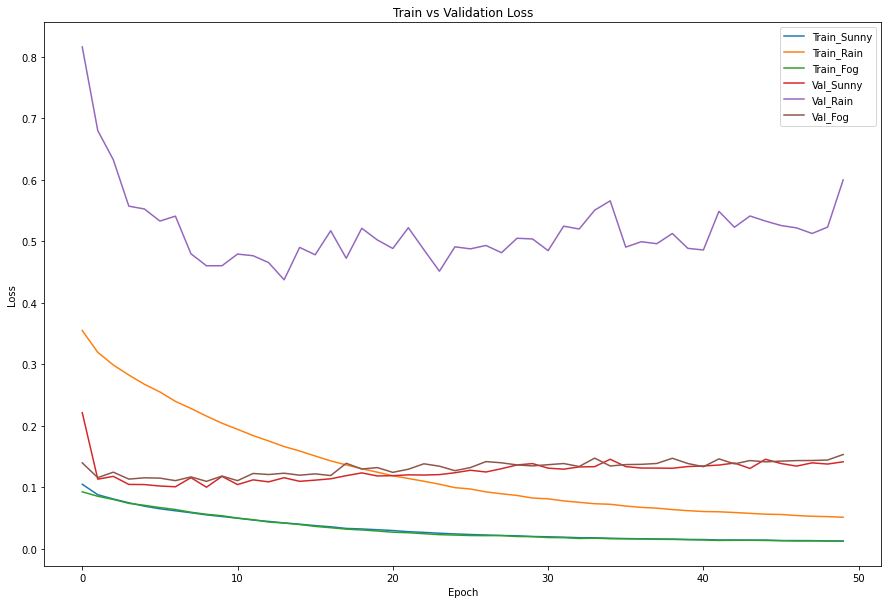

In [5]:
y1 = sunny_epoch_loss_list
y2 = rain_epoch_loss_list
y3 = fog_epoch_loss_list
y4 = sunny_val_epoch_loss_list
y5 = rain_val_epoch_loss_list
y6 = fog_val_epoch_loss_list
y7 = sunny_mAP_list
y8 = rain_mAP_list
y9 = fog_mAP_list
y10 = mAP_list
x = list(range(0,len(y1)))

plt.figure(figsize=(15,10))
plt.plot(x, y1, label = "Train_Sunny")
plt.plot(x, y2, label = "Train_Rain")
plt.plot(x, y3, label = "Train_Fog")
plt.plot(x, y4, label = "Val_Sunny")
plt.plot(x, y5, label = "Val_Rain")
plt.plot(x, y6, label = "Val_Fog")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

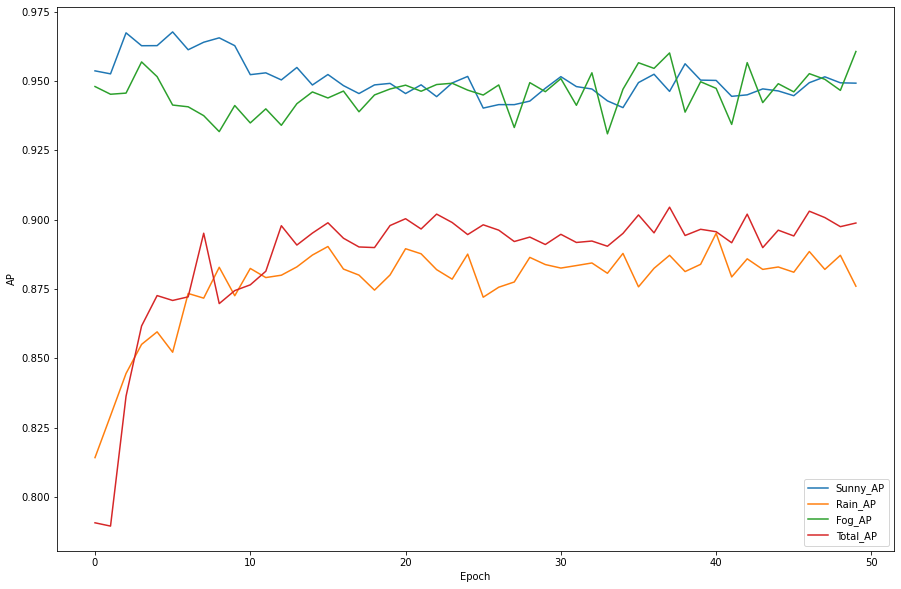

In [6]:
plt.figure(figsize=(15,10))
plt.plot(x, y7, label = "Sunny_AP")
plt.plot(x, y8, label = "Rain_AP")
plt.plot(x, y9, label = "Fog_AP")
plt.plot(x, y10, label = "Total_AP")

plt.xlabel('Epoch')
plt.ylabel('AP')
plt.legend()
plt.show()

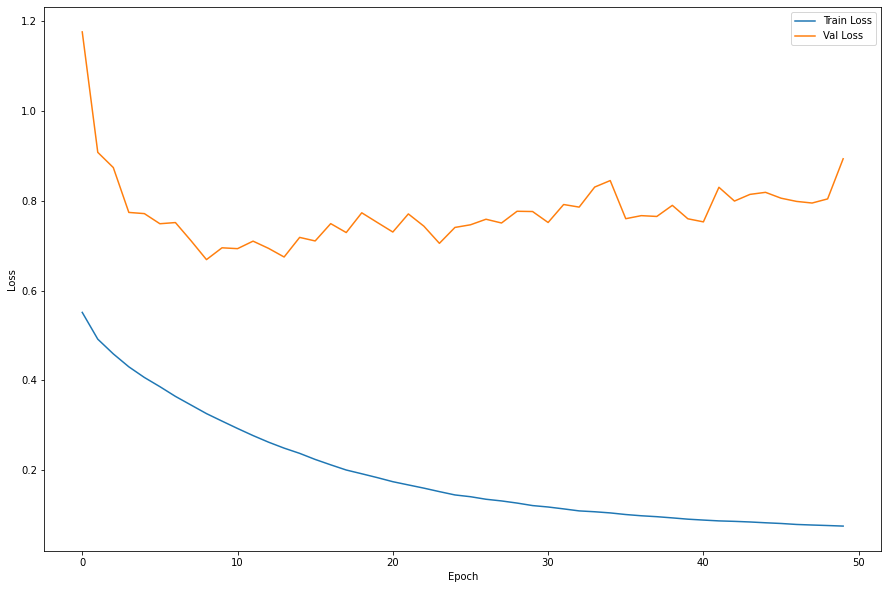

In [7]:
z1 = [a+b+c for a,b,c in zip(y1,y2,y3)]
z2 = [a+b+c for a,b,c in zip(y4,y5,y6)]
plt.figure(figsize=(15,10))
plt.plot(x, z1, label = "Train Loss")
plt.plot(x, z2, label = "Val Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()